## Установка зависимостей

In [1]:
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

import numpy as np
import scipy as scp
import pandas as pd
import librosa as ls
import matplotlib.pyplot as plt
import torch
import torchaudio as ta
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split as tts
import Levenshtein
import random

from typing import List, Tuple, Dict, Optional

/opt/anaconda3/envs/morseML/lib/python3.9/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/morseML/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <FB2FD416-6C4D-3621-B677-61F07C02A3C5> /opt/anaconda3/envs/morseML/lib/python3.9/site-packages/torchvision/image.so
  Reason: tried: '/opt/anaconda3/envs/morseML/lib/python3.9/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/morseML/lib/python3.9/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/morseML/lib/python3.9/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/morseML/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg`

## Исходные данные

In [2]:
AUDIO_DIR = "morse_dataset/morse_dataset"

Пример загрузки данных:

In [3]:
file = '1.opus'
file_path = f"{AUDIO_DIR}/{file}"
waveform, sample_rate = ls.load(file_path, sr=None)

print(f"Длина сигнала: {waveform.shape[0]}")
print(f"Частота дискретизации: {sample_rate}")
print(f"Длительность сигнала: {waveform.shape[0] / sample_rate:.2f} с")

Длина сигнала: 64000
Частота дискретизации: 8000
Длительность сигнала: 8.00 с


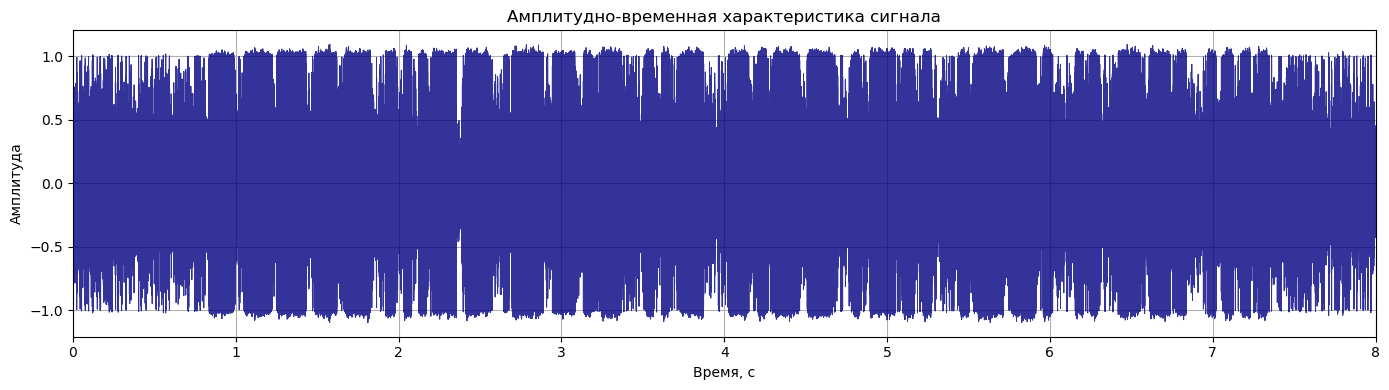

In [4]:
plt.figure(figsize=(14, 4))

plt.plot(np.linspace(0, waveform.shape[0] / sample_rate, num=waveform.shape[0]), waveform, c="navy", alpha=0.8, lw=0.7)
plt.title("Амплитудно-временная характеристика сигнала")
plt.xlabel("Время, с")
plt.ylabel("Амплитуда")
plt.xlim([0, waveform.shape[0] / sample_rate])
plt.grid()

plt.tight_layout()
plt.show()

*Note:* Сигнал зашумлен, хотя прослеживаются пики, отвечающие за точки и тире.

### Преобразование Фурье

In [5]:
# Амплитудно-частотная характеристика сигнала
signal = waveform / np.max(np.abs(waveform))
N = len(signal)
duration = N / sample_rate

yf = np.fft.fft(signal)
xf = np.fft.fftfreq(N, 1 / sample_rate)[:N//2]
magnitude = np.abs(yf[:N//2]) / N
magnitude_db = 20 * np.log10(magnitude + 1e-12)

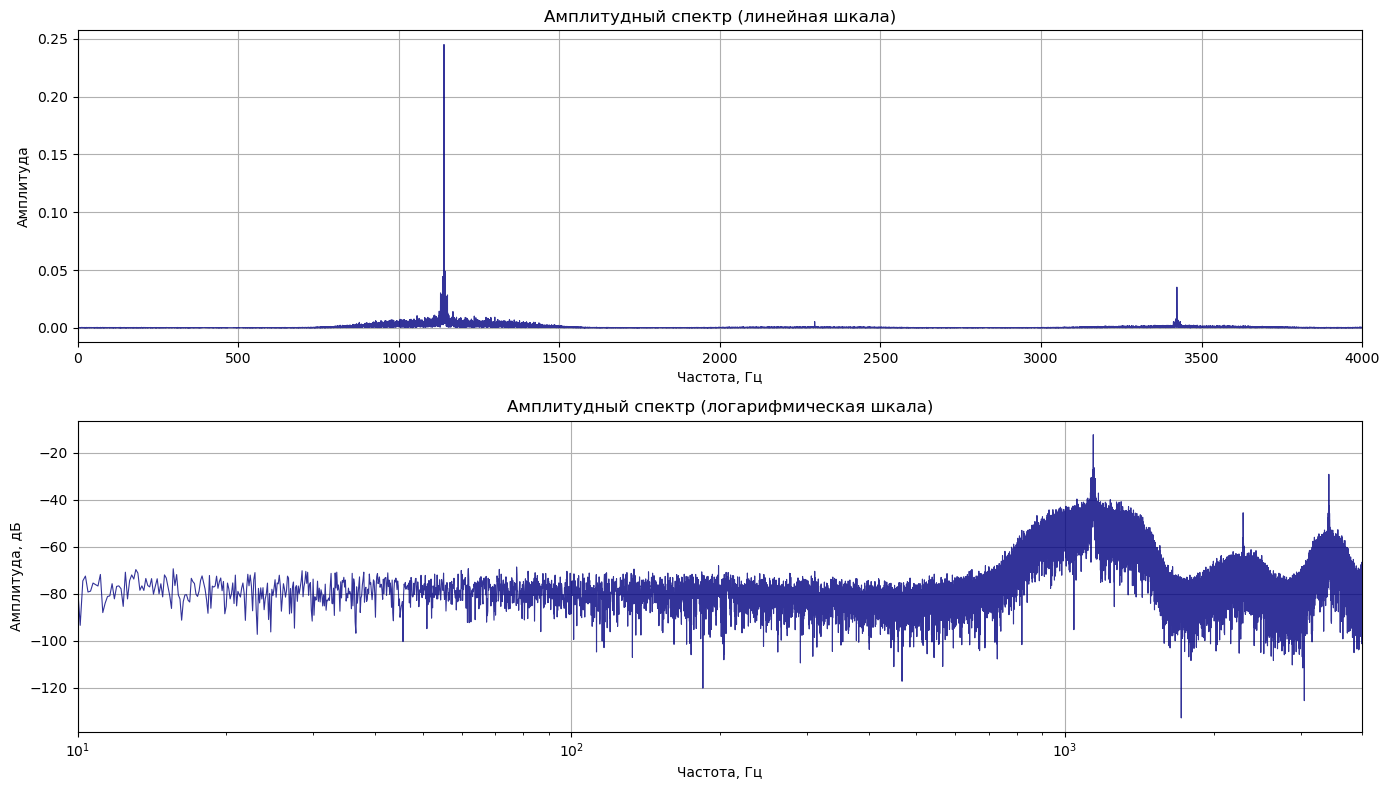

In [6]:
plt.figure(figsize=(14, 8))

plt.subplot(2, 1, 1)
plt.plot(xf, magnitude, c="navy", alpha=0.8, lw=0.8)
plt.title("Амплитудный спектр (линейная шкала)")
plt.xlabel("Частота, Гц")
plt.ylabel("Амплитуда")
plt.xlim([0, 4000])
plt.grid()

plt.subplot(2, 1, 2)
plt.semilogx(xf, magnitude_db, c="navy", alpha=0.8, lw=0.8)
plt.title("Амплитудный спектр (логарифмическая шкала)")
plt.xlabel("Частота, Гц")
plt.ylabel("Амплитуда, дБ")
plt.xlim(10, sample_rate / 2)
plt.grid()

plt.tight_layout()
plt.show()

Пример жесткой фильтрации аудиосигнала:

In [7]:
max_amp = np.argmax(magnitude)
cutoff_size = 150
magnitude_filt = [magnitude[i] if (max_amp - cutoff_size) < i < (max_amp + cutoff_size) 
                  else 0 for i in range(len(magnitude))]

yf_filt = np.zeros_like(yf, dtype=complex)
for i in range(len(magnitude_filt)):
    yf_filt[i] = yf[i] if magnitude_filt[i] != 0 else 0

for i in range(1, len(magnitude_filt)):
    yf_filt[-i] = np.conj(yf_filt[i])

# 2. Обратное преобразование Фурье
filtered_signal = np.real(np.fft.ifft(yf_filt))

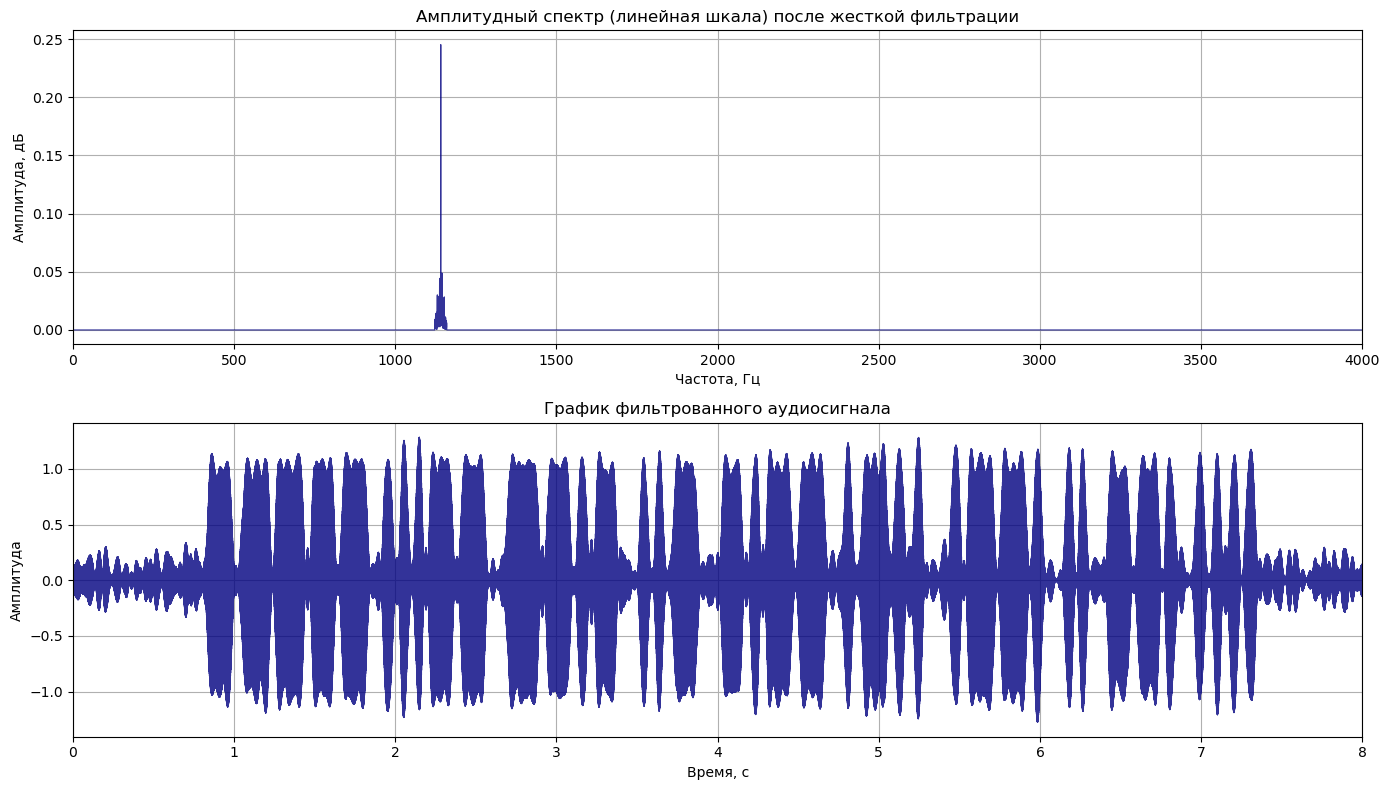

In [8]:
plt.figure(figsize=(14, 8))

plt.subplot(2, 1, 1)
plt.plot(xf, magnitude_filt, c="navy", alpha=0.8, lw=0.8)
plt.title("Амплитудный спектр (линейная шкала) после жесткой фильтрации")
plt.xlabel("Частота, Гц")
plt.ylabel("Амплитуда, дБ")
plt.xlim([0, 4000])
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(np.linspace(0, waveform.shape[0] / sample_rate, num=waveform.shape[0]), filtered_signal, c="navy", alpha=0.8, lw=0.7)
plt.title("График фильтрованного аудиосигнала")
plt.xlabel("Время, с")
plt.ylabel("Амплитуда")
plt.xlim([0, waveform.shape[0] / sample_rate])
plt.grid()

plt.tight_layout()
plt.show()

*Note:* Сигнал частично очистился от шумов, но детализация звука пострадала (пики сигналов имеют нечеткие границы).

### Разделение сигнала на гармоническую и ударную составляющие

In [9]:
# Спектрограмма с преобразованием Фурье
D = ls.stft(waveform)

# Разделение сигнала на составляющие
harmonic, percussive = ls.decompose.hpss(D)
y_harmonic = ls.istft(harmonic)
y_percussive = ls.istft(percussive)

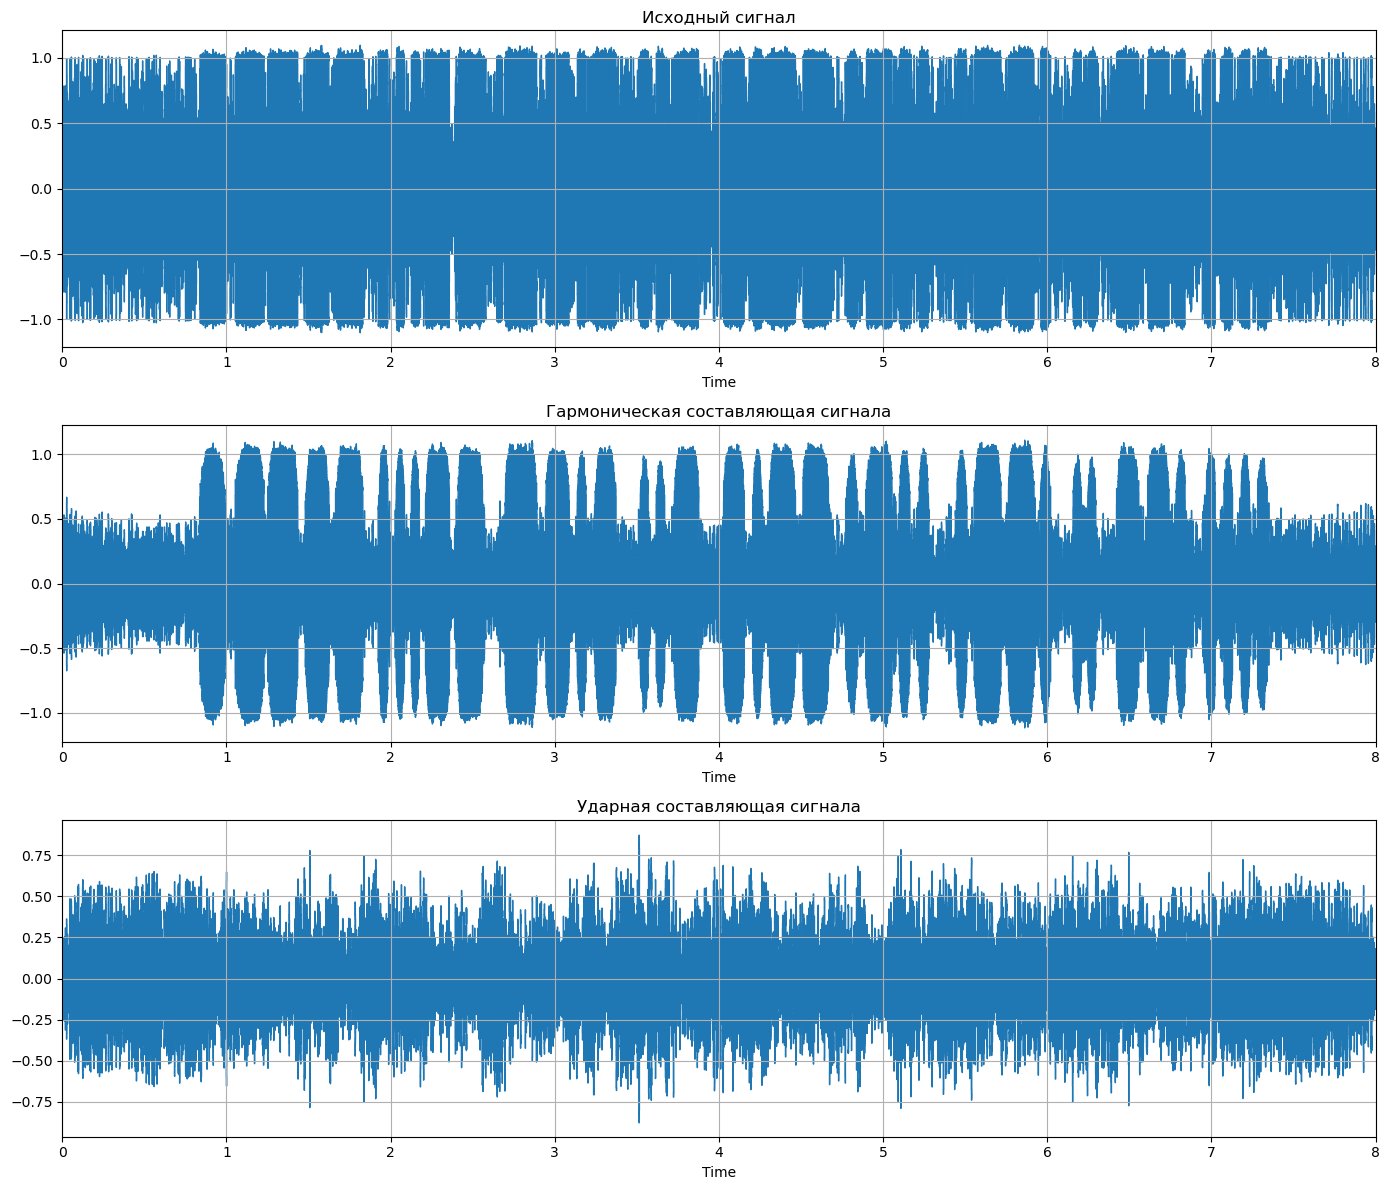

In [10]:
plt.figure(figsize=(14, 12))

plt.subplot(3, 1, 1)
ls.display.waveshow(waveform, sr=sample_rate)
plt.title('Исходный сигнал')
plt.xlim([0, waveform.shape[0] / sample_rate])
plt.grid()

plt.subplot(3, 1, 2)
ls.display.waveshow(y_harmonic, sr=sample_rate)
plt.title('Гармоническая составляющая сигнала')
plt.xlim([0, waveform.shape[0] / sample_rate])
plt.grid()

plt.subplot(3, 1, 3)
ls.display.waveshow(y_percussive, sr=sample_rate)
plt.title('Ударная составляющая сигнала')
plt.xlim([0, waveform.shape[0] / sample_rate])
plt.grid()

plt.tight_layout()
plt.show()

*Note:* Заметно, что нужную для распознавания информацию содержит только гармоническая составляющая сигнала.

### Составление и обработка Mel-спектрограммы

Составим mel-спектрограмму гармонической составляющей сигнала:

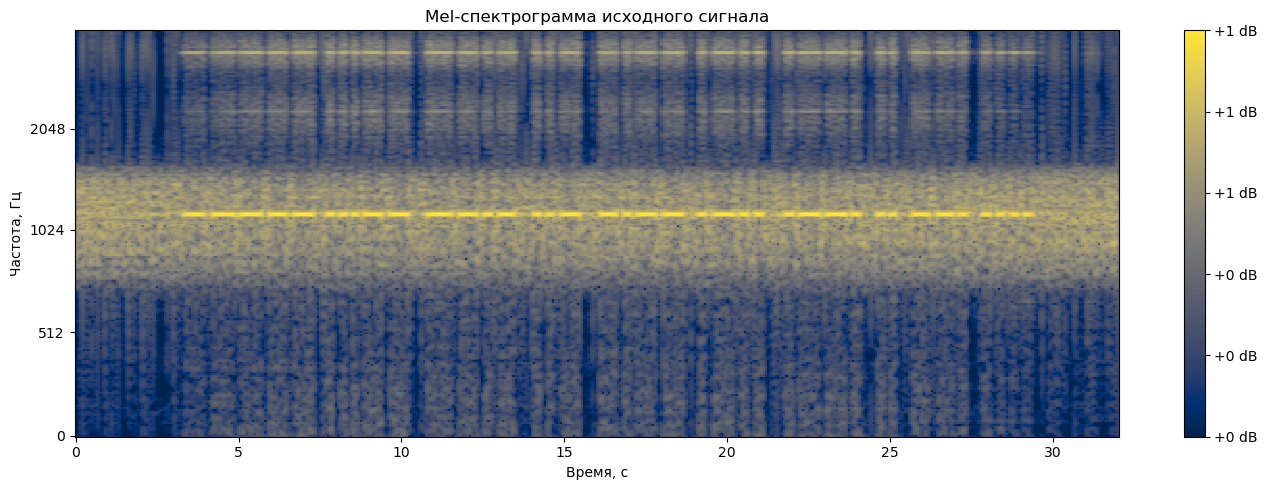

In [11]:
plt.figure(figsize=(14, 5))
S = ls.feature.melspectrogram(y=y_harmonic, sr=sample_rate, n_mels=256, n_fft=768, hop_length=128)
S_dB = ls.power_to_db(S, ref=np.max)
S_dB = (S_dB - S_dB.min()) / (S_dB.max() - S_dB.min())
ls.display.specshow(S_dB, sr=sample_rate, x_axis="time", y_axis="mel", cmap='cividis')

plt.colorbar(format="%+2.0f dB")
plt.title("Mel-спектрограмма исходного сигнала")
plt.xlabel("Время, с")
plt.ylabel("Частота, Гц")
plt.tight_layout()
plt.show()

Определим и применим bandpass-фильтр для того, чтобы убрать шумы за пределами доминирующей частоты:

In [12]:
def bandpass_filter(lowcut, highcut, waveform):
    nyquist = 0.5 * sample_rate
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = scp.signal.butter(4, [low, high], btype='band')
    
    return scp.signal.filtfilt(b, a, waveform)

def find_peak_freq(waveform):
    fft = np.fft.rfft(waveform)
    freqs = np.fft.rfftfreq(len(waveform), d=1/sample_rate)
    peak_idx = np.argmax(np.abs(fft))
    return freqs[peak_idx]

In [13]:
peak_freq = find_peak_freq(waveform)
cutoff = 50
lowcut, highcut = peak_freq - cutoff, peak_freq + cutoff
y_filtered = bandpass_filter(lowcut, highcut, y_harmonic)

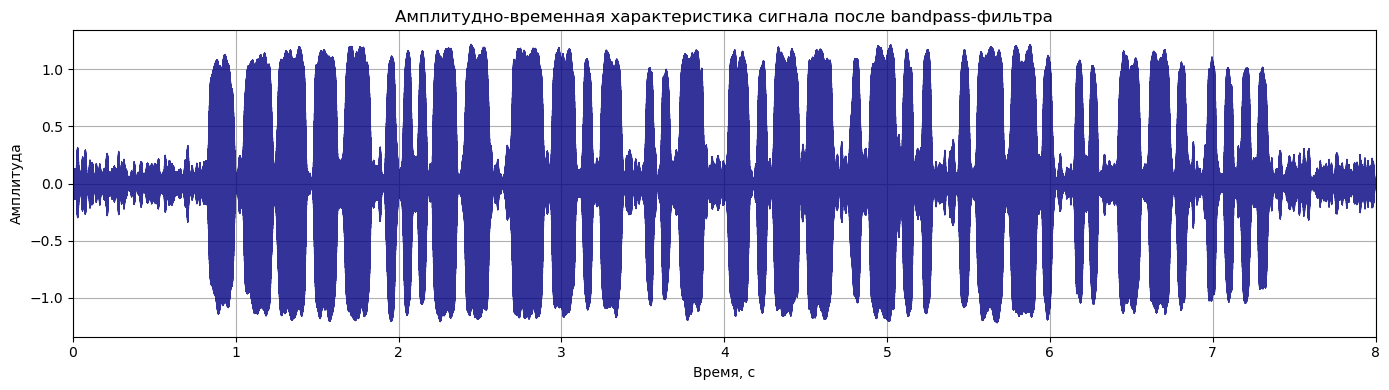

In [14]:
plt.figure(figsize=(14, 4))

plt.plot(np.linspace(0, waveform.shape[0] / sample_rate, num=waveform.shape[0]), y_filtered, c="navy", alpha=0.8, lw=0.7)
plt.title("Амплитудно-временная характеристика сигнала после bandpass-фильтра")
plt.xlabel("Время, с")
plt.ylabel("Амплитуда")
plt.xlim([0, waveform.shape[0] / sample_rate])
plt.grid()

plt.tight_layout()
plt.show()

*Note:* Заметим, что сигнал стал менее шумным, но на некоторых сигналах присутствует волнообразный характер амплитуды.

Применим RMS-нормализацию, чтобы сгладить волнообразность:

In [15]:
def normalize_waveform(waveform):
    frame_length = min(4096, len(waveform))
    hop_length = frame_length // 2
    rms = ls.feature.rms(y=waveform, hop_length=hop_length, frame_length=frame_length)[0]
    gain_rms = 0.95 / (rms + 1e-12)
    gain_rms = np.clip(gain_rms, 2.2, 3.0)

    waveform_rms = np.zeros_like(waveform)
    for i in range(len(rms)):
        start = i * 2048
        end = start + 4096
        waveform_rms[start:end] += waveform[start:end] * gain_rms[i]

    return waveform_rms / (np.max(np.abs(waveform_rms)) + 1e-12)

y_normalized = normalize_waveform(y_filtered)

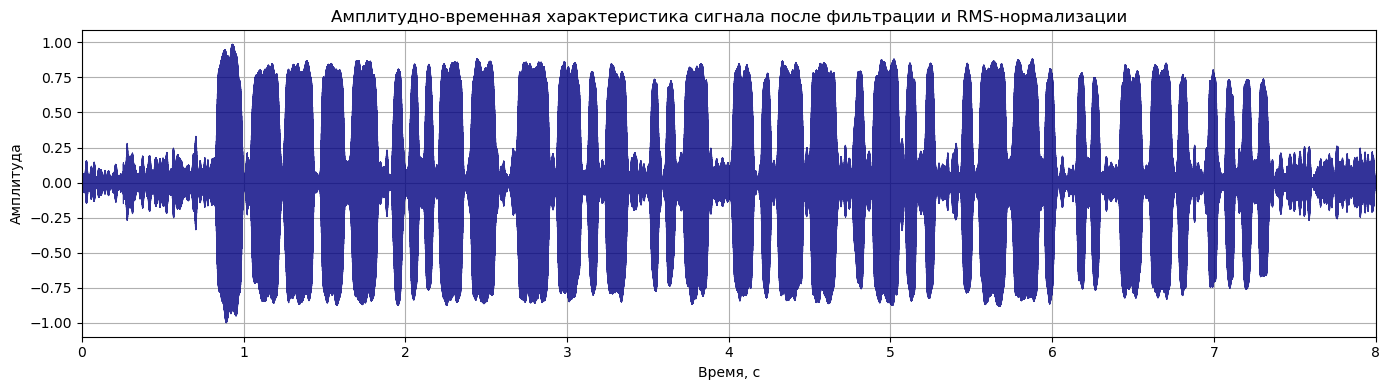

In [16]:
plt.figure(figsize=(14, 4))

plt.plot(np.linspace(0, waveform.shape[0] / sample_rate, num=waveform.shape[0]), y_normalized, c="navy", alpha=0.8, lw=0.7)
plt.title("Амплитудно-временная характеристика сигнала после фильтрации и RMS-нормализации")
plt.xlabel("Время, с")
plt.ylabel("Амплитуда")
plt.xlim([0, waveform.shape[0] / sample_rate])
plt.grid()

plt.tight_layout()
plt.show()

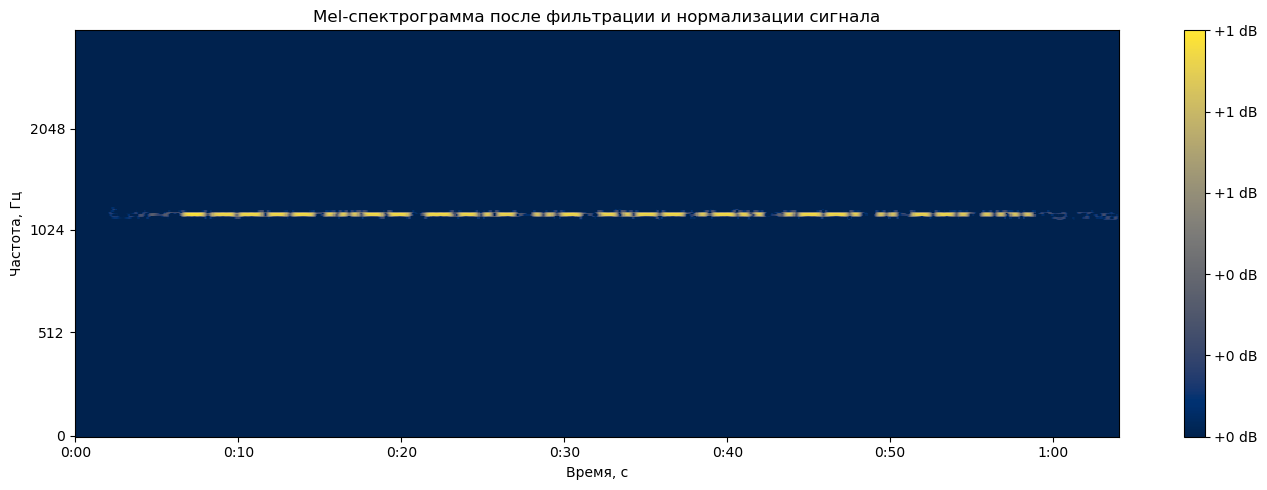

In [17]:
plt.figure(figsize=(14, 5))

power = 3.5
S_normalized = ls.feature.melspectrogram(y=y_normalized, sr=sample_rate, n_mels=256, n_fft=768, hop_length=64) ** power
S_dB_normalized = ls.power_to_db(S_normalized, ref=np.max)
S_dB_normalized = (S_dB_normalized - S_dB_normalized.min()) / (S_dB_normalized.max() - S_dB_normalized.min())
ls.display.specshow(S_dB_normalized, sr=sample_rate, x_axis="time", y_axis="mel", cmap='cividis')

plt.colorbar(format="%+2.0f dB")
plt.title("Mel-спектрограмма после фильтрации и нормализации сигнала")
plt.xlabel("Время, с")
plt.ylabel("Частота, Гц")
plt.tight_layout()
plt.show()

In [18]:
print(f"spec_shape: {S_dB_normalized.shape}")

spec_shape: (256, 1001)


Реализуем алгоритм поиска индекса, соответствующего максимальной частоте сигнала на спектрограмме:

In [19]:
def peak_freq_idx(spec):
    max_sum = 0
    for i in range(spec.shape[0]):
        if sum(spec[i]) > max_sum:
            peak_idx = i
            max_sum = sum(spec[i])

    return peak_idx

In [20]:
peak_idx = peak_freq_idx(S_dB_normalized)
print(f"peak_idx = {peak_idx}\npeak_freq = {peak_freq}")
S_dB_normalized = S_dB_normalized[(peak_idx - 5):(peak_idx + 5)]
print(f"spec_shape: {S_dB_normalized.shape}")

peak_idx = 123
peak_freq = 1141.0
spec_shape: (10, 1001)


## Реализация архитектуры нейросети

Пайплайн будет выглядеть следующим образом: Custom CNN -> BiLSTM -> CTC Loss + Greedy Decoder. Данные будут подаваться в сверточную сеть для извлечения признаков, затем они будут передаваться в BiLSTM для работы с временными зависимостями и после будет использован CTC Loss + Greedy Decoder для формирования предсказаний в символах.

In [21]:
def set_seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # если используется несколько GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.mps.manual_seed(seed)  # Для MPS (Apple Silicon)
    
    # Для PyTorch Lightning
    pl.seed_everything(seed, workers=True)

# Применяем в начале скрипта
set_seed_everything(42)

Global seed set to 42


Реализуем класс `AudioPreprocessing`:

In [22]:
class AudioPreprocessing:
    def __init__(self, path, sr=8000):
        self.sr = sr
        self.path = path
        self.waveform = self.load_audio()

    def load_audio(self):
        waveform, _ = ls.load(self.path, sr=self.sr)
        return waveform

    def signal_partition(self):
        D = ls.stft(self.waveform)
        harmonic, _ = ls.decompose.hpss(D)
        y_harmonic = ls.istft(harmonic)
        return y_harmonic
    
    def find_peak_freq(self):
        wf = self.waveform
        fft = np.fft.rfft(wf)
        freqs = np.fft.rfftfreq(len(wf), d=1/self.sr)
        peak_idx = np.argmax(np.abs(fft))
        return freqs[peak_idx]
    
    def bandpass_filtering(self, lowcut, highcut):
        wf = self.signal_partition()
        nyquist = 0.5 * self.sr
        low = lowcut / nyquist
        high = highcut / nyquist
        b, a = scp.signal.butter(4, [low, high], btype='band')
        return scp.signal.filtfilt(b, a, wf)
    
    def signal_filtering(self, cutoff=50):
        peak_freq = self.find_peak_freq()
        lowcut, highcut = peak_freq - cutoff, peak_freq + cutoff
        y_filtered = self.bandpass_filtering(lowcut, highcut)
        return y_filtered
    
    def normalize_waveform(self):
        wf = self.signal_filtering()
        frame_length = min(4096, len(wf))
        hop_length = frame_length // 2
        rms = ls.feature.rms(y=wf, hop_length=hop_length, frame_length=frame_length)[0]
        gain_rms = 0.95 / (rms + 1e-12)
        gain_rms = np.clip(gain_rms, 2.2, 3.0)
        waveform_rms = np.zeros_like(wf)
        for i in range(len(rms)):
            start = i * 2048
            end = start + 4096
            waveform_rms[start:end] += wf[start:end] * gain_rms[i]
        return waveform_rms / (np.max(np.abs(waveform_rms)) + 1e-12)
    
    def spec_processing(self, power=3.5):
        wf = self.normalize_waveform()
        S = ls.feature.melspectrogram(
            y=wf,
            sr=self.sr,
            n_mels=256, 
            n_fft=768,
            hop_length=64) ** power
        S_dB = ls.power_to_db(S, ref=np.max)
        S_dB = (S_dB - S_dB.min()) / (S_dB.max() - S_dB.min())
        return S_dB
    
    def peak_freq_selection(self):
        max_sum = 0
        peak_idx = 0
        spec = self.spec_processing()
        
        for i in range(spec.shape[0]):
            current_sum = sum(spec[i])
            if current_sum > max_sum:
                peak_idx = i
                max_sum = current_sum

        spectrogram = spec[(peak_idx - 5):(peak_idx + 5)]
        return spectrogram
    
path = f"{AUDIO_DIR}/1.opus"
audio = AudioPreprocessing(path)
spectrogram = audio.peak_freq_selection()
spectrogram.shape

(10, 1001)

Проверим корректность реализованного класса:

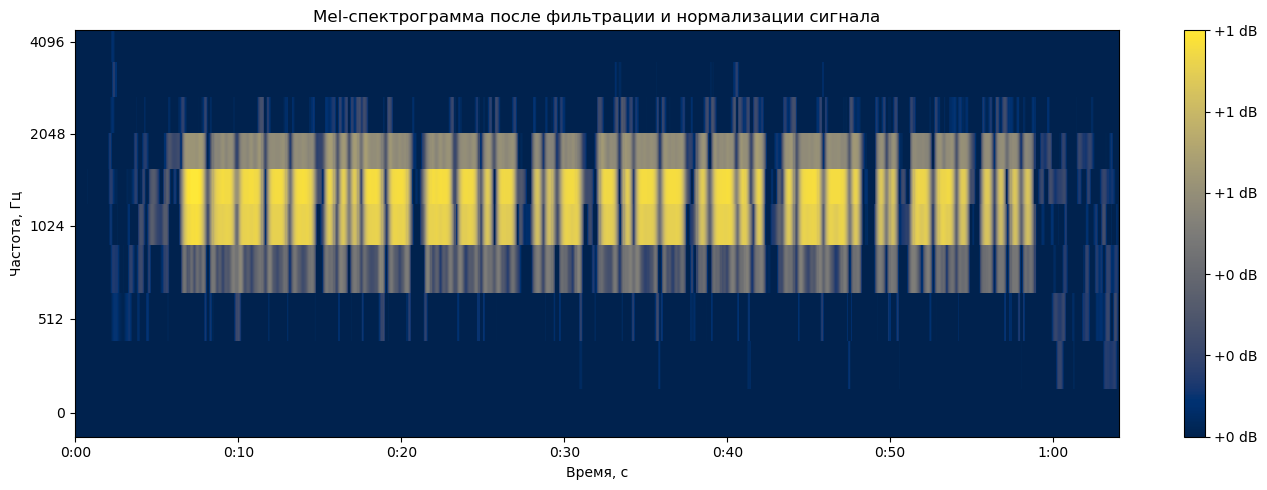

In [23]:
plt.figure(figsize=(14, 5))

ls.display.specshow(audio.peak_freq_selection(), sr=sample_rate, x_axis="time", y_axis="mel", cmap='cividis')

plt.colorbar(format="%+2.0f dB")
plt.title("Mel-спектрограмма после фильтрации и нормализации сигнала")
plt.xlabel("Время, с")
plt.ylabel("Частота, Гц")
plt.tight_layout()
plt.show()

In [24]:
class MorseDataset(Dataset):
    def __init__(self, data: List[Dict], mode: str = 'train', audio_dir=AUDIO_DIR):
        """
        Dataset для обработки спектрограмм и сообщений Морзе.
        
        Args:
            data: Список словарей с ключами 'spec' и 'message' (для train/val)
                  или только 'spec' (для test)
            mode: Режим работы ('train', 'val', 'test')
        """
        self.data = data
        self.mode = mode
        self.token_to_index = self._build_token_to_index()
        self.audio_dir = audio_dir
        
    # def _build_char_to_index(self) -> Dict[str, int]:
    #     """Создает словарь для преобразования символов в индексы."""
    #     russian_letters = 'АБВГДЕЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ'
    #     numbers = '0123456789'
    #     symbols = [' ', '#']  # пробел и символ для CTC blank
    #     vocab = ['<blank>'] + list(russian_letters) + list(numbers) + symbols
    #     return {char: idx for idx, char in enumerate(vocab)}

    def _build_token_to_index(self):
        vocab = ['<blank>', '.', '-', ' ', '/']
        return {token: idx for idx, token in enumerate(vocab)}
    
    def __len__(self) -> int:
        return len(self.data)
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:
        item = self.data.iloc[idx]
        path = f"{self.audio_dir}/{item['id']}"
        audio = AudioPreprocessing(path)
        spec = torch.FloatTensor(audio.peak_freq_selection())  # Спектрограмма
        
        if self.mode == 'test':
            return spec, None

        # Преобразуем сообщение в индексы
        message = item['message']
        targets = [self.token_to_index[char] for char in message]
        targets = torch.LongTensor(targets)
        
        return spec, targets

In [25]:
def collate_fn(batch: List[Tuple[torch.Tensor, Optional[torch.Tensor]]]) -> Tuple[torch.Tensor, Optional[torch.Tensor], torch.Tensor, Optional[torch.Tensor]]:
    """
    Функция для объединения элементов батча.
    
    Возвращает:
        specs: Тензор спектрограмм (batch_size, channels, freq, time)
        spec_lengths: Длины спектрограмм
        targets: Тензор с целевыми последовательностями (если есть)
        target_lengths: Длины целевых последовательностей (если есть)
    """
    specs, targets = zip(*batch)
    
    # Выравнивание по длине с помощью паддинга
    specs = torch.nn.utils.rnn.pad_sequence(specs, batch_first=True)
    specs = specs.unsqueeze(1)  # Добавляем размерность канала
    
    # Длины спектрограмм (до паддинга)
    spec_lengths = torch.LongTensor([spec.shape[-1] for spec in specs])
    
    if targets[0] is None:
        return specs, spec_lengths, None, None
    
    # Выравнивание целевых последовательностей
    targets = torch.nn.utils.rnn.pad_sequence(targets, batch_first=True, padding_value=0)
    target_lengths = torch.LongTensor([len(t) for t in targets])
    
    return specs, spec_lengths, targets, target_lengths

In [26]:
class MorseModel(pl.LightningModule):
    def __init__(self, num_classes: int, learning_rate: float = 1e-4, weight_decay: float = 1e-6):
        super().__init__()
        self.save_hyperparameters()
        self.token_to_index = self._build_token_to_index()
        
        # CNN с дилатациями
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, dilation=2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Dropout(0.1),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.AdaptiveAvgPool2d((1, None))
        )
        
        # LSTM
        self.lstm = nn.LSTM(
            input_size=256,
            hidden_size=96,
            num_layers=1,
            bidirectional=True,
            batch_first=True)
        
        # Классификатор
        self.fc = nn.Linear(192, num_classes)  # 256 = 128*2 (bidirectional)
        
        # CTC Loss
        self.ctc_loss = nn.CTCLoss(blank=0, reduction='mean', zero_infinity=True)
        
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
    
    def forward(self, x: torch.Tensor, x_lengths: torch.Tensor) -> torch.Tensor:
        # CNN
        x = self.cnn(x)  # (batch, channels, height, time)
        # print(x.shape)
        x = x.squeeze(2)  # Удаляем высоту после avgpool (batch, channels, time)
        # print(x.shape)
        x = x.permute(0, 2, 1)  # (batch, time, channels)
        # print(x.shape)
        x_lengths = torch.IntTensor([x.shape[1]] * x.shape[0])
        
        # LSTM
        x = nn.utils.rnn.pack_padded_sequence(x, x_lengths.cpu(), batch_first=True, enforce_sorted=False)
        x, _ = self.lstm(x)
        x, _ = nn.utils.rnn.pad_packed_sequence(x, batch_first=True)
        
        # Классификатор
        x = self.fc(x)  # (batch, time, num_classes)
        x = F.log_softmax(x, dim=-1)
        
        return x
    
    def training_step(self, batch, batch_idx):
        specs, spec_lengths, targets, target_lengths = batch
        log_probs = self(specs, spec_lengths)  # не передаём spec_lengths, если не нужно

        # print(f"log_probs.shape: {log_probs.shape}")  # (B, T, C)

        # Новый spec_lengths на основе длины log_probs по времени
        batch_size = log_probs.size(0)
        spec_lengths = torch.full(
            size=(batch_size,),
            fill_value=log_probs.size(1),
            dtype=torch.long,
            device=log_probs.device
        )

        # print(f"spec_lengths (adjusted): {spec_lengths}")
        # print(f"target_lengths: {target_lengths}")
        # print(spec_lengths >= target_lengths)
        
        # Подготовка для CTC: (T, N, C)
        log_probs = log_probs.permute(1, 0, 2)

        # print(f"log_probs min: {log_probs.min()}, max: {log_probs.max()}")
        # print(f"targets unique: {targets.unique()}")

        loss = self.ctc_loss(log_probs, targets, spec_lengths, target_lengths)
        self.log('train_loss', loss, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        specs, spec_lengths, targets, target_lengths = batch
        log_probs = self(specs, spec_lengths)

        batch_size = log_probs.size(0)
        spec_lengths = torch.full(
            size=(batch_size,),
            fill_value=log_probs.size(1),
            dtype=torch.long,
            device=log_probs.device
        )
        
        log_probs = log_probs.permute(1, 0, 2)
        loss = self.ctc_loss(log_probs, targets, spec_lengths, target_lengths)
        
        # Декодирование для валидации
        decoded = self._greedy_decode(log_probs.permute(1, 0, 2))
        
        # Преобразуем targets и decoded в текстовый вид для метрик
        targets_text = self._indices_to_text(targets)
        decoded_text = self._indices_to_text(decoded)
        
        # Вычисляем метрики
        cer = self._calculate_cer(decoded_text, targets_text)
        lev_dist = self._calculate_levenshtein(decoded_text, targets_text)
        
        self.log_dict({
            'val_loss': loss,
            'val_cer': cer,
            'val_levenshtein': lev_dist
        }, prog_bar=True)
        return loss
    
    def _indices_to_text(self, sequences: List[List[int]]) -> List[str]:
        """Преобразует последовательности индексов в текстовые строки."""
        index_to_char = {v: k for k, v in self.token_to_index.items()}
        texts = []
        for seq in sequences:
            text = ''.join([index_to_char.get(idx, '') for idx in seq])
            texts.append(text)
        return texts
    
    def _calculate_cer(self, decoded: List[str], targets: List[str]) -> float:
        """Вычисляет Character Error Rate (CER)."""
        total_chars = 0
        total_errors = 0
        
        for pred, true in zip(decoded, targets):
            total_chars += len(true)
            total_errors += Levenshtein.distance(pred, true)
        
        return total_errors / max(total_chars, 1)
    
    def _calculate_levenshtein(self, decoded: List[str], targets: List[str]) -> float:
        """Вычисляет среднее расстояние Левенштейна."""
        distances = []
        for pred, true in zip(decoded, targets):
            distances.append(Levenshtein.distance(pred, true))
        return sum(distances) / max(len(distances), 1)
    
    def _build_token_to_index(self):
        vocab = ['<blank>', '.', '-', ' ', '/']
        return {token: idx for idx, token in enumerate(vocab)}
    
    def _greedy_decode(self, log_probs: torch.Tensor) -> List[List[int]]:
        """Жадное декодирование выхода CTC."""
        _, max_indices = torch.max(log_probs, dim=2)
        decoded = []
        for seq in max_indices:
            # Удаление повторяющихся символов и blank
            prev = None
            decoded_seq = []
            for idx in seq:
                if idx != prev and idx != 0:  # 0 - blank
                    decoded_seq.append(idx.item())
                prev = idx
            decoded.append(decoded_seq)
        return decoded
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=1e-5)  # Сильно уменьшите lr
        return {
            "optimizer": optimizer,
            "gradient_clip_val": 0.5,  # Жесткий клиппинг
            "gradient_clip_algorithm": "value"
        }

In [43]:
def seed_worker(worker_id):
    set_seed_everything(42 + worker_id)

def train(train_data: List[Dict], val_data: List[Dict], num_classes: int, 
                train_batch_size: int, val_batch_size: int, max_epochs: int):
    set_seed_everything(42)

    # Создаем датасеты
    train_dataset = MorseDataset(train_data, mode='train')
    val_dataset = MorseDataset(val_data, mode='val')
    
    # Создаем даталоадеры
    train_loader = DataLoader(
        train_dataset,
        batch_size=train_batch_size,
        shuffle=True,
        collate_fn=collate_fn,
        num_workers=8,
        # persistent_workers=True,
        worker_init_fn=seed_worker)
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=val_batch_size,
        shuffle=False,
        collate_fn=collate_fn,
        num_workers=4,
        # persistent_workers=True,
        worker_init_fn=seed_worker)
    
    # Инициализируем модель
    model = MorseModel(num_classes=num_classes)
    
    # Создаем тренер
    trainer = pl.Trainer(
        max_epochs=max_epochs,
        accelerator='auto',
        devices='auto',
        log_every_n_steps=10,
        check_val_every_n_epoch=1)
    
    # Обучаем модель
    trainer.fit(model, train_loader, val_loader)
    
    return model

Импортируем датасеты и преобразуем их к требуемому виду:

In [28]:
train_set_draft = pd.read_csv("train.csv")
test_set_draft = pd.read_csv("test.csv")

Создадим словарь морзянки для шифрования/дешифрования символьных последовательностей:

In [29]:
morse_dict = {
    '.-': 'А', '-...': 'Б', '.--': 'В', '--.': 'Г', '-..': 'Д',
    '.': 'Е', '...-': 'Ж', '--..': 'З', '..': 'И', '.---': 'Й',
    '-.-': 'К', '.-..': 'Л', '--': 'М', '-.': 'Н', '---': 'О', 
    '.--.': 'П', '.-.': 'Р', '...': 'С', '-': 'Т', '..-': 'У',
    '..-.': 'Ф', '....': 'Х', '-.-.': 'Ц', '---.': 'Ч', '----': 'Ш',
    '--.-': 'Щ', '.--.-.': 'Ъ', '-.--': 'Ы', '-..-': 'Ь', '..-..': 'Э',
    '..--': 'Ю', '.-.-': 'Я',

    '-----': '0', '.----': '1', '..---': '2', '...--': '3', '....-': '4',
    '.....': '5', '-....': '6', '--...': '7', '---..': '8', '----.': '9',
    
    '--.--': '#', '/': ' '
}
inv_morse_dict = {value: key for key, value in morse_dict.items()}

In [30]:
train_set_draft.head()

,id,message
0,1.opus,03ЩУЫЛПИГХ
1,2.opus,ЪЛТ0ДС6А3Г
2,3.opus,5ЭКЫБЗХЯН
3,4.opus,ЖЫЦОИ68КФ
4,5.opus,32Ю7МЫ ЗЛ


Реализуем функцию для перевода расшифровки сообщения в трейновом датасете в морзянку:

In [31]:
def message_to_morse(row):
    return ' '.join([inv_morse_dict[char] for char in list(row['message'])])

In [32]:
train_set = train_set_draft.copy()
train_set['message'] = train_set.apply(message_to_morse, axis=1)

In [33]:
train_set.head()

,id,message
0,1.opus,----- ...-- --.- ..- -.-- .-.. .--. .. --. ....
1,2.opus,.--.-. .-.. - ----- -.. ... -.... .- ...-- --.
2,3.opus,..... ..-.. -.- -.-- -... --.. .... .-.- -.
3,4.opus,...- -.-- -.-. --- .. -.... ---.. -.- ..-.
4,5.opus,...-- ..--- ..-- --... -- -.-- / --.. .-..


In [34]:
train_data, val_data = tts(train_set, test_size=0.15, random_state=42)

Пробный запуск:

In [35]:
# Создаем датасеты
train_dataset = MorseDataset(train_data, mode='train')
val_dataset = MorseDataset(val_data, mode='val')

# Создаем даталоадеры
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    collate_fn=collate_fn,
    # num_workers=10,
    # persistent_workers=True,
    worker_init_fn=lambda worker_id: set_seed_everything(42 + worker_id))

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    collate_fn=collate_fn,
    # num_workers=10,
    # persistent_workers=True,
    worker_init_fn=lambda worker_id: set_seed_everything(42 + worker_id))

model = MorseModel(num_classes=5)

In [36]:
def show_batch(batch):
    specs, _, targets, _ = batch
    plt.figure(figsize=(12, 4))
    plt.imshow(specs[0].squeeze().cpu().numpy(), aspect='auto')
    plt.title(f"Target: {targets[0]}")
    plt.show()

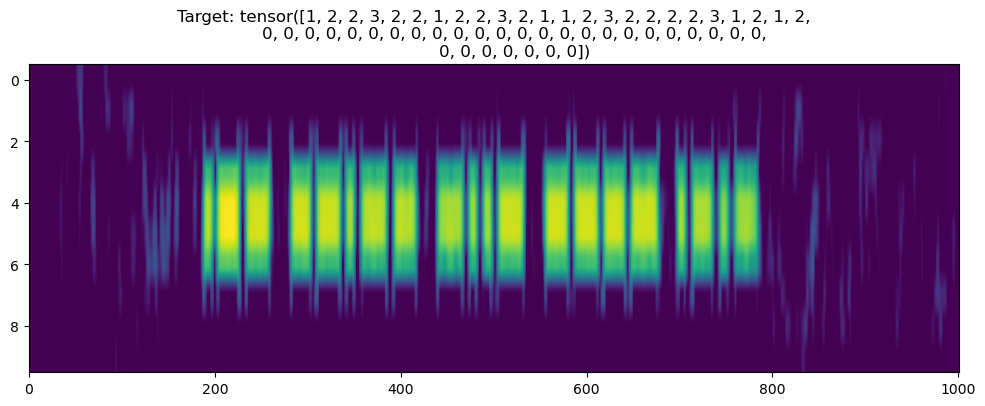

Batch shapes: [torch.Size([32, 1, 10, 1001]), torch.Size([32]), torch.Size([32, 55]), torch.Size([32])]
Model output shape: torch.Size([32, 999, 5])


In [37]:
# Перед обучением
test_batch = next(iter(train_loader))
show_batch(test_batch)
print("Batch shapes:", [t.shape for t in test_batch if t is not None])

# Тестовый forward
with torch.no_grad():
    model.train()
    test_out = model(test_batch[0], test_batch[1])
    print("Model output shape:", test_out.shape)

In [38]:
model.train()
with torch.no_grad():
    test_batch = next(iter(train_loader))
    loss = model.training_step(test_batch, 0)
    print("Test batch loss:", loss)

Test batch loss: tensor(21.0952)


/opt/anaconda3/envs/morseML/lib/python3.9/site-packages/pytorch_lightning/core/module.py:413: UserWarning: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`
  rank_zero_warn(


## Обучение

In [ ]:
train(
    train_data=train_data,
    val_data=val_data,
    num_classes=5,
    train_batch_size=16,
    val_batch_size=16,
    max_epochs=50
)